In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report
import seaborn as sns

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# == DATASET LOADING AND PREPROCESSING == #
print("Loading NusaX-Sentiment dataset...")

# Load the datasets
train_url = 'https://drive.google.com/uc?id=1EjwYiF0n6SB9b4pjOC9OgERiW-qFs1Xv'
valid_url = 'https://drive.google.com/uc?id=10nEhcFT5WYRQL462zAsYGrKH9h09Ll9X'
test_url = 'https://drive.google.com/uc?id=1mvbRKOWCx3CFh57NLr-_uV77Zr-uC7Bw'

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df = pd.read_csv(test_url)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

# Display dataset info
print("\nDataset columns:", train_df.columns.tolist())
print("\nFirst few training samples:")
print(train_df.head())

# Check label distribution
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

# Prepare the data
X_train = train_df['text'].values
y_train = train_df['label'].values
X_val = valid_df['text'].values
y_val = valid_df['label'].values
X_test = test_df['text'].values
y_test = test_df['label'].values

# Create label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print(f"\nLabel mapping: {label_mapping}")

# Convert labels to numeric
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

num_classes = len(label_mapping)
print(f"Number of classes: {num_classes}")

Loading NusaX-Sentiment dataset...
Training samples: 500
Validation samples: 100
Test samples: 400

Dataset columns: ['id', 'text', 'label']

First few training samples:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

Label distribution in training set:
label
negative    192
positive    189
neutral     119
Name: count, dtype: int64

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Number of classes: 3


In [4]:
# == TEXT PREPROCESSING == #
print("\nSetting up text preprocessing...")

# Define preprocessing parameters
MAX_FEATURES = 10000  # Size of vocabulary
MAX_LENGTH = 100      # Maximum sequence length
EMBEDDING_DIM = 128   # Embedding dimension

# Create TextVectorization layer
vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=MAX_LENGTH,
    output_mode='int'
)

# Adapt the vectorizer to the training data
vectorizer.adapt(X_train)

# Transform text data to sequences
X_train_seq = vectorizer(X_train)
X_val_seq = vectorizer(X_val)
X_test_seq = vectorizer(X_test)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")
print(f"Sequence shape: {X_train_seq.shape}")



Setting up text preprocessing...
Vocabulary size: 2836
Sequence shape: (500, 100)


In [5]:
# == MODEL BUILDING FUNCTIONS == #
def create_rnn_model(num_rnn_layers=1, rnn_units=[128], bidirectional=True, embedding_dim=EMBEDDING_DIM):
    model = keras.Sequential()
    # Embedding layer
    model.add(layers.Embedding(
        input_dim=MAX_FEATURES,
        output_dim=embedding_dim,
        input_length=MAX_LENGTH
    ))
    # Add RNN layers
    for i in range(min(num_rnn_layers, len(rnn_units))):
        return_sequences = (i < num_rnn_layers - 1)  # Return sequences for all but last layer
        if bidirectional:
            model.add(layers.Bidirectional(
                layers.SimpleRNN(
                    units=rnn_units[i],
                    return_sequences=return_sequences,
                    dropout=0.2,
                    recurrent_dropout=0.2
                )
            ))
        else:
            model.add(layers.SimpleRNN(
                units=rnn_units[i],
                return_sequences=return_sequences,
                dropout=0.2,
                recurrent_dropout=0.2
            ))

    # First Dropout layer
    model.add(layers.Dropout(0.5))

    # First Dense layer with ReLU activation
    model.add(layers.Dense(128, activation='relu'))

    # Second Dropout layer
    model.add(layers.Dropout(0.3))

    # Second Dense layer with softmax activation for multiclass classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Custom F1 Score callback
class MacroF1Score(keras.callbacks.Callback):

    def __init__(self, validation_data):
        super(MacroF1Score, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val, y_pred_classes, average='macro')
        self.f1_scores.append(f1)
        print(f" - val_f1_score: {f1:.4f}")

def train_and_evaluate_model(model, epochs=10, batch_size=64):
    # Create callback for F1 score
    f1_callback = MacroF1Score(validation_data=(X_val_seq, y_val_numeric))

    # Train the model
    history = model.fit(
        X_train_seq, y_train_numeric,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_seq, y_val_numeric),
        callbacks=[f1_callback],
        verbose=1
    )

    # Evaluate on test set
    y_pred = model.predict(X_test_seq)
    y_pred_classes = np.argmax(y_pred, axis=1)
    test_f1 = f1_score(y_test_numeric, y_pred_classes, average='macro')
    print(f"Test Macro F1 Score: {test_f1:.4f}")
    return history, f1_callback.f1_scores, test_f1

def plot_training_history(history, title="Training History", include_f1=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Plot F1 score if provided
    if include_f1 is not None:
        epochs = len(include_f1)
        ax2.plot(range(epochs), include_f1, label='Validation Macro F1')
    ax2.set_title(f'{title} - Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()
    plt.tight_layout()
    return fig


=== Experiment a: Varying Number of RNN Layers ===

Training model with 1 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.3212 - loss: 1.2406 - val_f1_score: 0.3190
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3248 - loss: 1.2382 - val_accuracy: 0.4300 - val_loss: 1.0805
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3436 - loss: 1.1877 - val_f1_score: 0.3312
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.3432 - loss: 1.1937 - val_accuracy: 0.4400 - val_loss: 1.0804
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3386 - loss: 1.1480 - val_f1_score: 0.2726
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3424 - loss: 1.1515 - val_accuracy: 0.3600 - val_loss: 1.0810
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3985 - loss: 1.1588 - val_f1_score: 0.2127
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3957 - loss: 1.1594 - val_accuracy: 0.3600 - val_loss: 1.0910
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3923 - loss: 1.1655 - val_f1_score: 0.3006
8/8 ━━━━━━━━━━

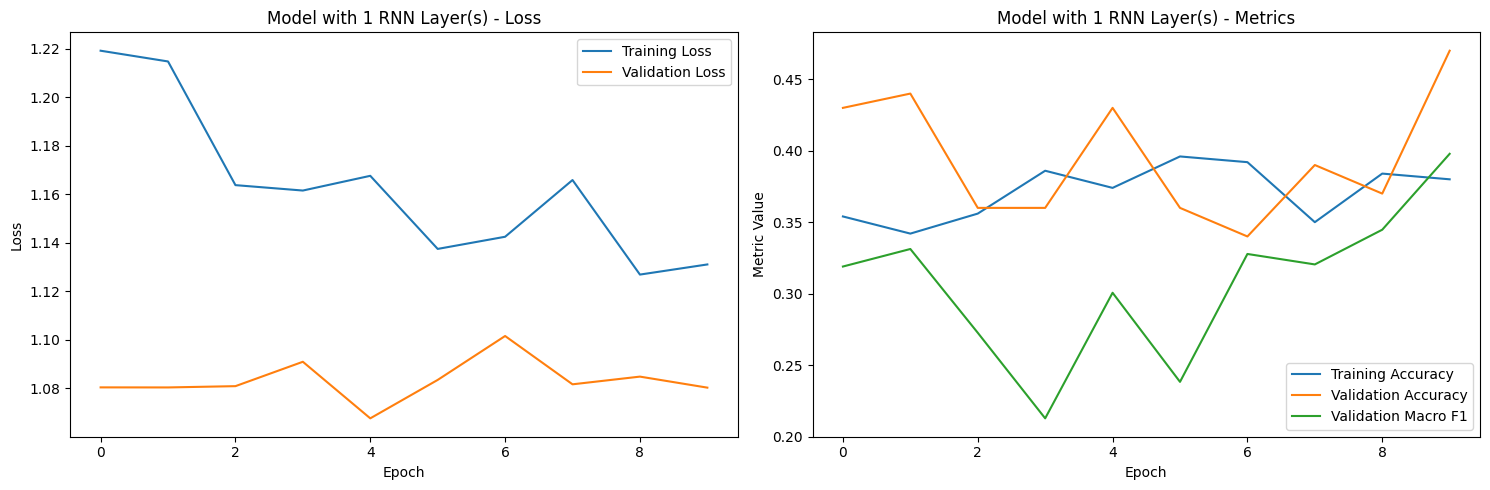


Training model with 2 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.3683 - loss: 1.2722 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3682 - loss: 1.2737 - val_accuracy: 0.3800 - val_loss: 1.1736
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3684 - loss: 1.2544 - val_f1_score: 0.1784
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3684 - loss: 1.2522 - val_accuracy: 0.2600 - val_loss: 1.1663
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4008 - loss: 1.1791 - val_f1_score: 0.2830
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3913 - loss: 1.2015 - val_accuracy: 0.3400 - val_loss: 1.1056
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4291 - loss: 1.1273 - val_f1_score: 0.2216
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4191 - loss: 1.1439 - val_accuracy: 0.3400 - val_loss: 1.1395
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4015 - loss: 1.1651 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━

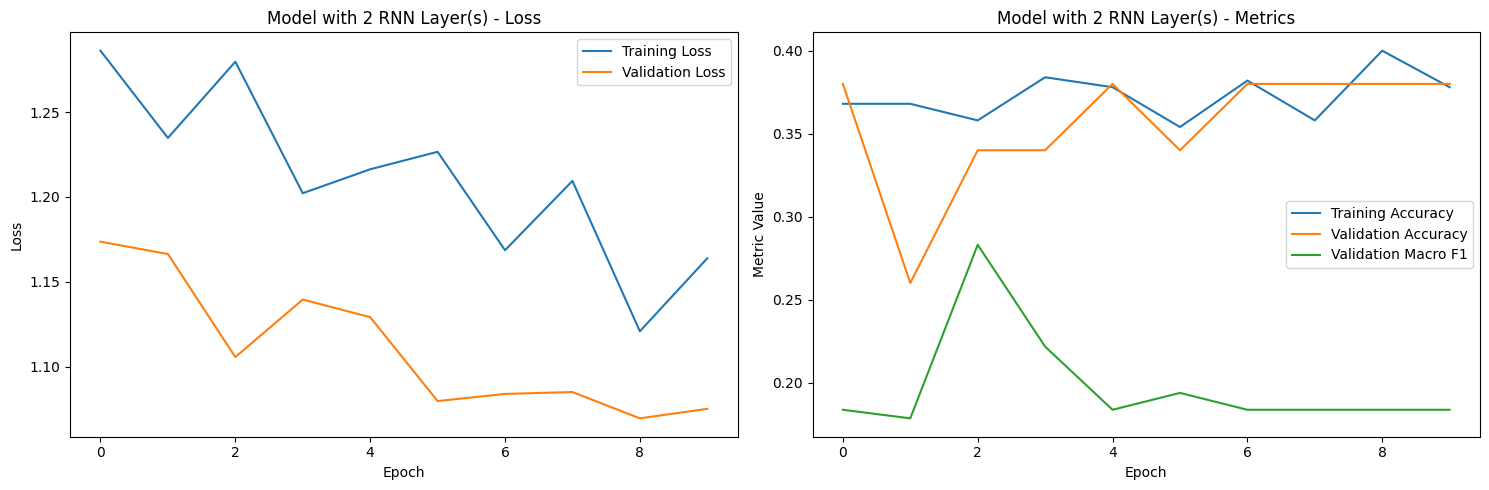


Training model with 3 RNN layer(s)...
Model architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3077 - loss: 1.6045   - val_f1_score: 0.1967
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3098 - loss: 1.5965 - val_accuracy: 0.3700 - val_loss: 1.1411
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3187 - loss: 1.3554 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.3199 - loss: 1.3574 - val_accuracy: 0.3800 - val_loss: 1.2015
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3226 - loss: 1.3678 - val_f1_score: 0.3446
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3246 - loss: 1.3657 - val_accuracy: 0.4700 - val_loss: 1.0635
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3901 - loss: 1.2678 - val_f1_score: 0.3280
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3894 - loss: 1.2667 - val_accuracy: 0.4300 - val_loss: 1.0615
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3614 - loss: 1.2629 - val_f1_score: 0.3362
8/8 ━━━━━━━

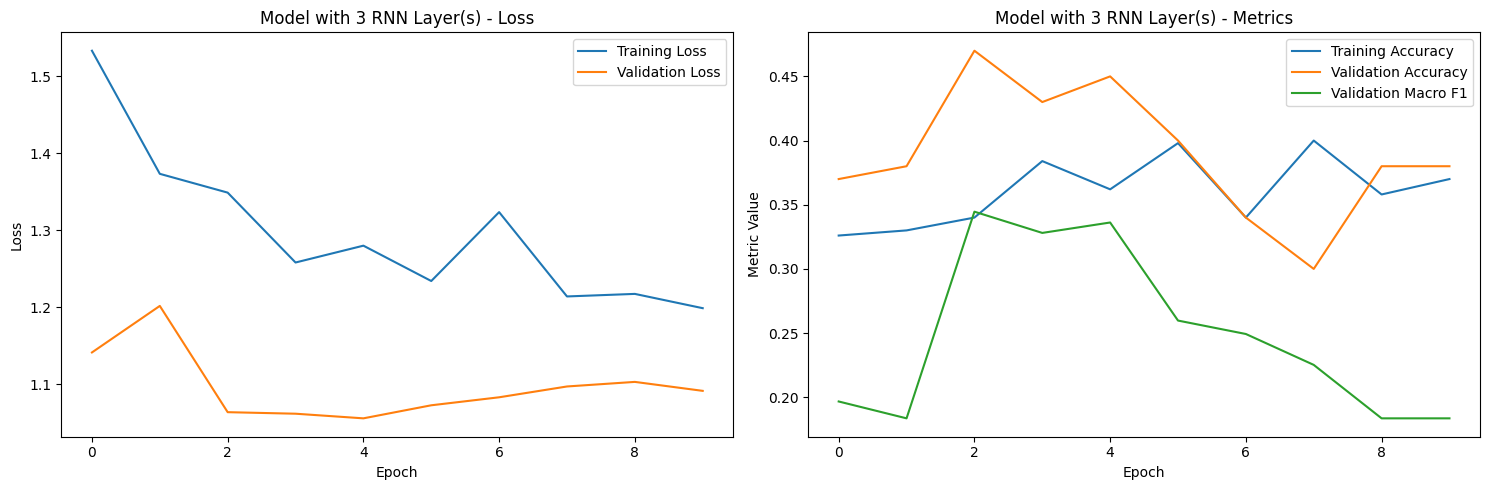

In [6]:
# == EXPERIMENT EXECUTION == #

# a. VARYING NUMBER OF RNN LAYERS
print("\n=== Experiment a: Varying Number of RNN Layers ===")
rnn_layer_results = []
for num_layers in [1, 2, 3]:
    print(f"\nTraining model with {num_layers} RNN layer(s)...")
    model = create_rnn_model(
        num_rnn_layers=num_layers,
        rnn_units=[128] * num_layers,
        bidirectional=True
    )
    print(f"Model architecture:")
    model.summary()
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    rnn_layer_results.append({
        'num_layers': num_layers,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with {num_layers} RNN Layer(s)",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment b: Varying Number of RNN Units ===

Training model with RNN units: 64-64
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.3574 - loss: 1.2406 - val_f1_score: 0.2728
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3577 - loss: 1.2381 - val_accuracy: 0.4100 - val_loss: 1.0768
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3734 - loss: 1.1665 - val_f1_score: 0.2152
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.3753 - loss: 1.1684 - val_accuracy: 0.3900 - val_loss: 1.0690
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3948 - loss: 1.1727 - val_f1_score: 0.2281
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3897 - loss: 1.1777 - val_accuracy: 0.3900 - val_loss: 1.0632
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3219 - loss: 1.2135 - val_f1_score: 0.3230
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3232 - loss: 1.2156 - val_accuracy: 0.4600 - val_loss: 1.0602
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3670 - loss: 1.1920 - val_f1_score: 0.3401
8/8 ━━━━━━━━━━━━━━━━━━━━ 

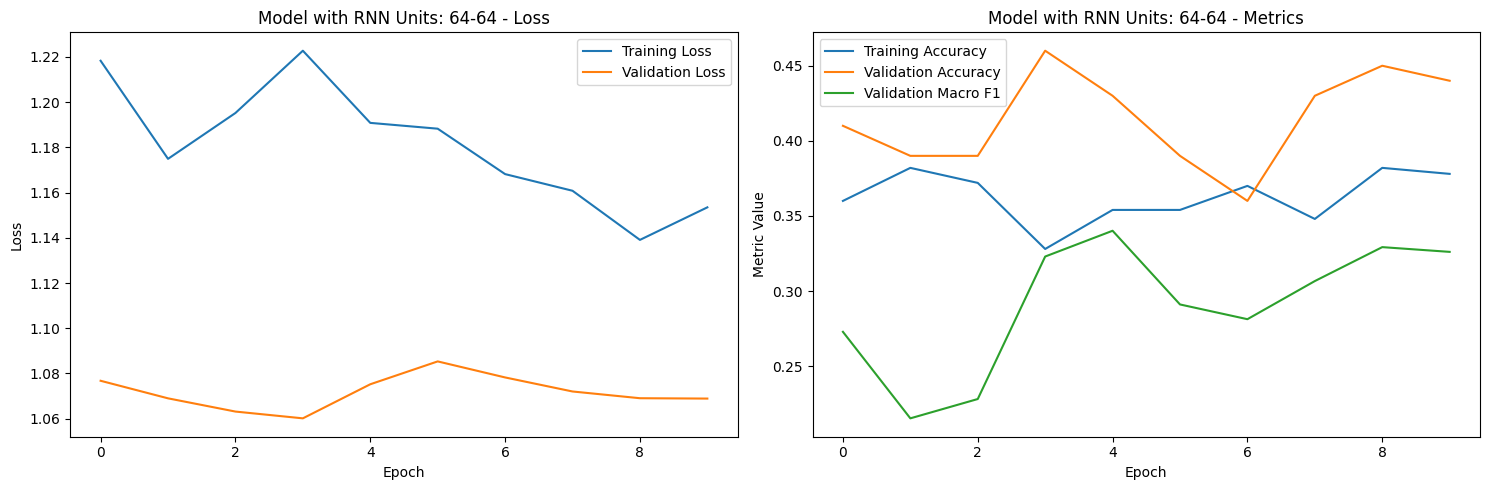


Training model with RNN units: 128-128
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.3733 - loss: 1.2320 - val_f1_score: 0.1765
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3698 - loss: 1.2383 - val_accuracy: 0.3600 - val_loss: 1.0803
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3706 - loss: 1.2131 - val_f1_score: 0.2656
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3705 - loss: 1.2179 - val_accuracy: 0.3500 - val_loss: 1.0584
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3808 - loss: 1.2880 - val_f1_score: 0.2020
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3828 - loss: 1.2865 - val_accuracy: 0.3900 - val_loss: 1.0975
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3781 - loss: 1.2095 - val_f1_score: 0.2522
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3745 - loss: 1.2114 - val_accuracy: 0.2700 - val_loss: 1.1054
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3152 - loss: 1.2423 - val_f1_score: 0.2367
8/8 ━━━━━━━━━━━━━━━━━━━━ 

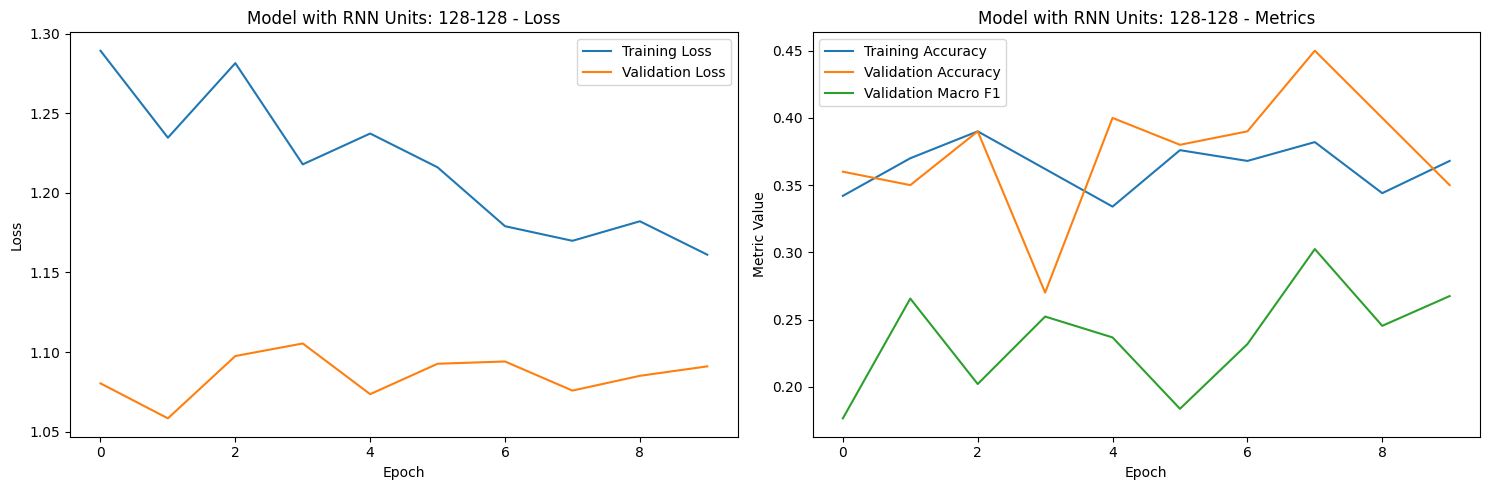


Training model with RNN units: 256-256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.3280 - loss: 1.4490 - val_f1_score: 0.3816
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3269 - loss: 1.4466 - val_accuracy: 0.5000 - val_loss: 1.0357
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3423 - loss: 1.3675 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3429 - loss: 1.3630 - val_accuracy: 0.3800 - val_loss: 1.1472
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3791 - loss: 1.2233 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3774 - loss: 1.2287 - val_accuracy: 0.3800 - val_loss: 1.1083
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3436 - loss: 1.2935 - val_f1_score: 0.2940
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3410 - loss: 1.2949 - val_accuracy: 0.3900 - val_loss: 1.0659
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3802 - loss: 1.1950 - val_f1_score: 0.1940
8/8 ━━━━━━━━━━

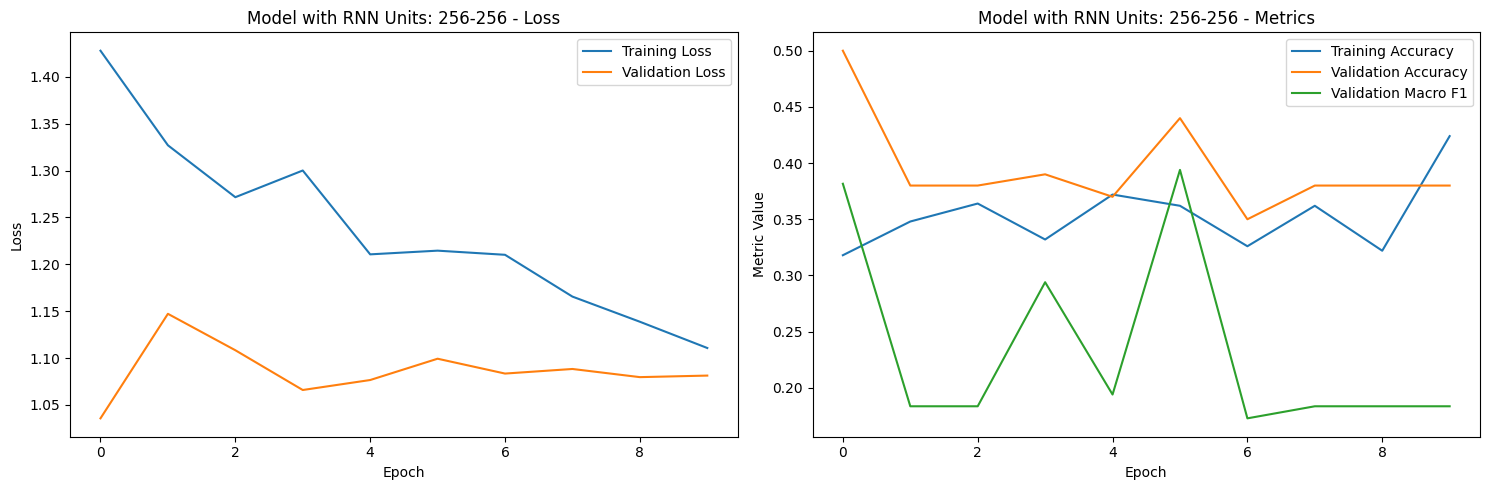

In [7]:
# b. VARYING NUMBER OF RNN UNITS
print("\n=== Experiment b: Varying Number of RNN Units ===")
units_results = []
units_configs = [
    [64, 64],
    [128, 128],
    [256, 256]
]
for units in units_configs:
    units_str = '-'.join(map(str, units))
    print(f"\nTraining model with RNN units: {units_str}")
    model = create_rnn_model(
        num_rnn_layers=len(units),
        rnn_units=units,
        bidirectional=True
    )
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    units_results.append({
        'units': units,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with RNN Units: {units_str}",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment c: Varying RNN Direction ===

Training model with Bidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.2791 - loss: 1.4556 - val_f1_score: 0.2475
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2796 - loss: 1.4476 - val_accuracy: 0.4100 - val_loss: 1.1076
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3423 - loss: 1.2237 - val_f1_score: 0.3335
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.3489 - loss: 1.2207 - val_accuracy: 0.4400 - val_loss: 1.0967
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3215 - loss: 1.2674 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3269 - loss: 1.2655 - val_accuracy: 0.3800 - val_loss: 1.1429
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4145 - loss: 1.1936 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4086 - loss: 1.1967 - val_accuracy: 0.3800 - val_loss: 1.1020
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3811 - loss: 1.2129 - val_f1_score: 0.2116
8/8 ━━━━━━━━━━━━━━━━━━━━ 

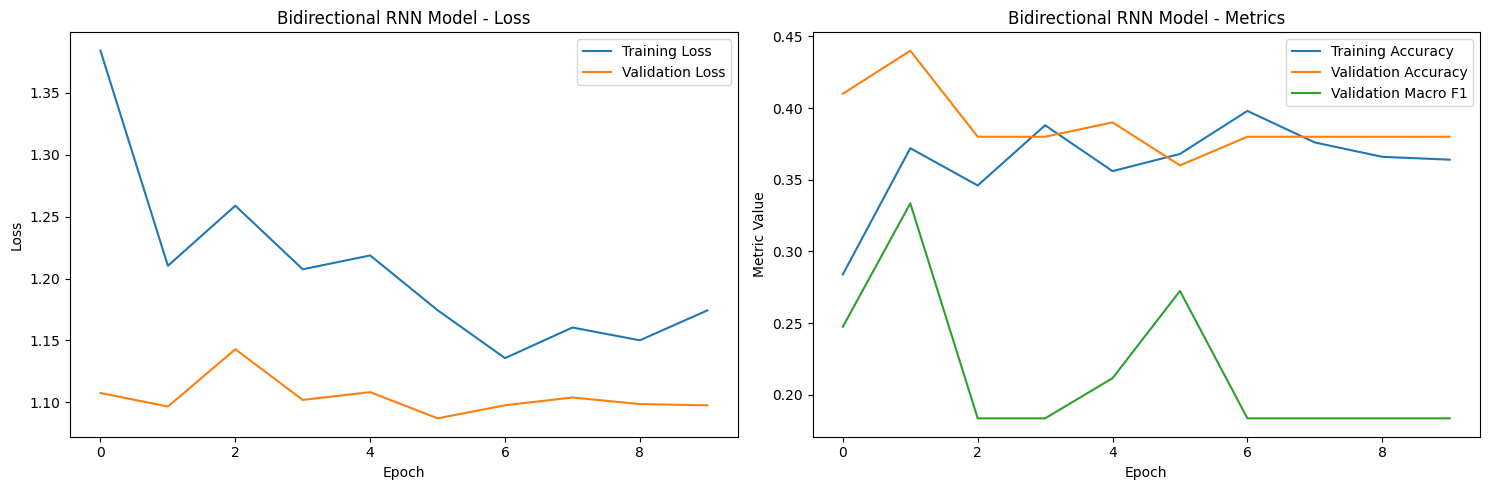


Training model with Unidirectional RNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.3530 - loss: 1.2590 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 829ms/step - accuracy: 0.3504 - loss: 1.2622 - val_accuracy: 0.3800 - val_loss: 1.1076
Epoch 2/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3746 - loss: 1.2312 - val_f1_score: 0.1952
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3749 - loss: 1.2358 - val_accuracy: 0.3500 - val_loss: 1.1132
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3781 - loss: 1.2340 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3741 - loss: 1.2347 - val_accuracy: 0.3800 - val_loss: 1.0882
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3803 - loss: 1.1808 - val_f1_score: 0.1940
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3794 - loss: 1.1833 - val_accuracy: 0.3700 - val_loss: 1.0806
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3580 - loss: 1.1833 - val_f1_score: 0.3938
8/8 ━━━━━━━━━━━━━━━━━━

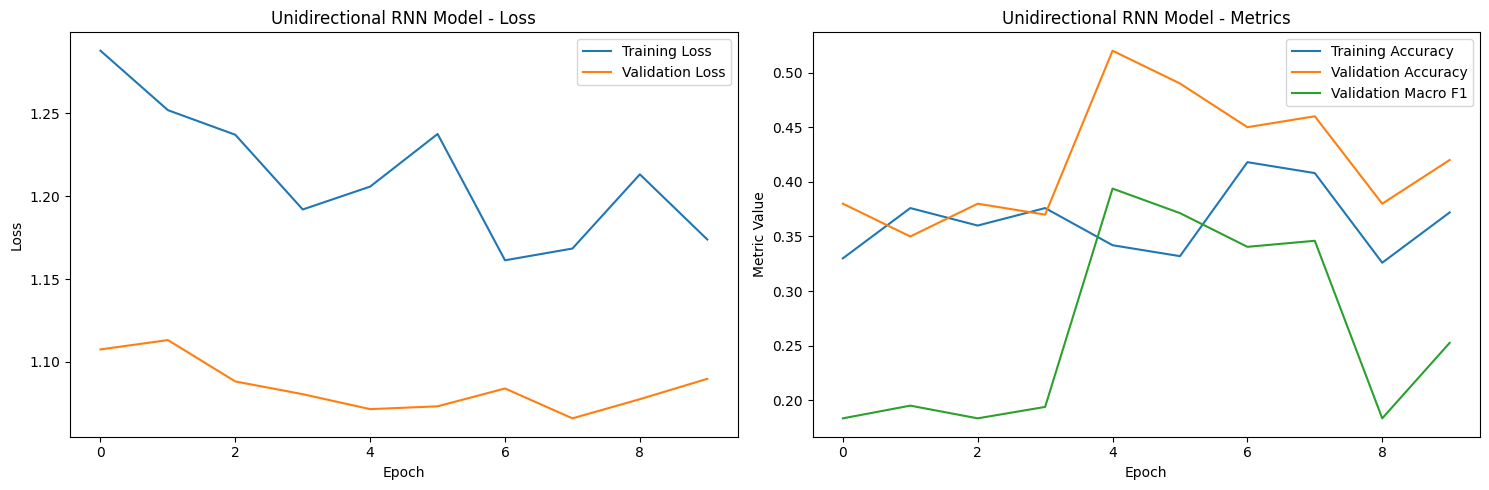

In [8]:
# c. VARYING RNN DIRECTION (Bidirectional vs Unidirectional)
print("\n=== Experiment c: Varying RNN Direction ===")
direction_results = []
for bidirectional in [True, False]:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\nTraining model with {direction_name} RNN...")
    model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=bidirectional
    )
    history, f1_scores, test_f1 = train_and_evaluate_model(model, epochs=10)
    direction_results.append({
        'bidirectional': bidirectional,
        'direction_name': direction_name,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })
    # Plot the training history
    plot_training_history(
        history,
        title=f"{direction_name} RNN Model",
        include_f1=f1_scores
    )
    plt.show()

In [9]:
# == RESULTS ANALYSIS == #
print("\n=== Results Summary ===")
# a. Number of RNN Layers Results
print("\nNumber of RNN Layers:")
for result in rnn_layer_results:
    print(f"Layers: {result['num_layers']} - Test F1: {result['test_f1']:.4f}")
# b. Number of RNN Units Results
print("\nNumber of RNN Units:")
for result in units_results:
    units_str = '-'.join(map(str, result['units']))
    print(f"Units: {units_str} - Test F1: {result['test_f1']:.4f}")
# c. RNN Direction Results
print("\nRNN Direction:")
for result in direction_results:
    print(f"Direction: {result['direction_name']} - Test F1: {result['test_f1']:.4f}")


=== Results Summary ===

Number of RNN Layers:
Layers: 1 - Test F1: 0.2880
Layers: 2 - Test F1: 0.1844
Layers: 3 - Test F1: 0.1827

Number of RNN Units:
Units: 64-64 - Test F1: 0.2845
Units: 128-128 - Test F1: 0.2908
Units: 256-256 - Test F1: 0.1844

RNN Direction:
Direction: Bidirectional - Test F1: 0.1844
Direction: Unidirectional - Test F1: 0.1846


In [10]:
# == SAVE THE BEST MODEL == #
# Find the model with the highest test F1 score
all_results = rnn_layer_results + units_results + direction_results
best_result = max(all_results, key=lambda x: x['test_f1'])
# Create and train the best model for saving
print("\n=== Training Best Model for Saving ===")
if 'num_layers' in best_result:
    print(f"Best model: {best_result['num_layers']} RNN layers")
    best_model = create_rnn_model(
        num_rnn_layers=best_result['num_layers'],
        rnn_units=[128] * best_result['num_layers'],
        bidirectional=True
    )
elif 'units' in best_result:
    units_str = '-'.join(map(str, best_result['units']))
    print(f"Best model: RNN units {units_str}")
    best_model = create_rnn_model(
        num_rnn_layers=len(best_result['units']),
        rnn_units=best_result['units'],
        bidirectional=True
    )
else:  # 'bidirectional' in best_result
    print(f"Best model: {best_result['direction_name']} RNN")
    best_model = create_rnn_model(
        num_rnn_layers=2,
        rnn_units=[128, 128],
        bidirectional=best_result['bidirectional']
    )
# Train the best model
history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=10)
print(f"Best model test F1 Score: {test_f1:.4f}")
# Save the best model and vectorizer
best_model.save('best_rnn_model.h5')
print("Best model saved to 'best_rnn_model.h5'")
# Save the vectorizer weights for later use
import pickle
vectorizer_config = vectorizer.get_config()
vectorizer_weights = vectorizer.get_weights()
with open('vectorizer_config.pkl', 'wb') as f:
    pickle.dump({'config': vectorizer_config, 'weights': vectorizer_weights}, f)
print("Vectorizer saved to 'vectorizer_config.pkl'")


=== Training Best Model for Saving ===
Best model: RNN units 128-128
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.3350 - loss: 1.4091 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3371 - loss: 1.4036 - val_accuracy: 0.3800 - val_loss: 1.1665
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3430 - loss: 1.3324 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3457 - loss: 1.3308 - val_accuracy: 0.3800 - val_loss: 1.1651
Epoch 3/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4144 - loss: 1.1997 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4076 - loss: 1.2076 - val_accuracy: 0.3800 - val_loss: 1.1245
Epoch 4/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3881 - loss: 1.2194 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3845 - loss: 1.2276 - val_accuracy: 0.3800 - val_loss: 1.1879
Epoch 5/10
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3896 - loss: 1.2201 - val_f1_score: 0.1836
8/8 ━━━━━━━━━━━━━━━━━━━━ 

Test Macro F1 Score: 0.2278
Best model test F1 Score: 0.2278
Best model saved to 'best_rnn_model.h5'
Vectorizer saved to 'vectorizer_config.pkl'


In [11]:
# == CONCLUSIONS == #
print("\n=== Experiment Conclusions ===")
# a. Number of RNN Layers
print("\nEffect of Number of RNN Layers:")
max_rnn_layer = max(rnn_layer_results, key=lambda x: x['test_f1'])
print(f"Best number of RNN layers: {max_rnn_layer['num_layers']} (F1: {max_rnn_layer['test_f1']:.4f})")
print("Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,")
print("            but too many layers may lead to vanishing gradient problems and overfitting.")
# b. Number of RNN Units
print("\nEffect of Number of RNN Units:")
max_units = max(units_results, key=lambda x: x['test_f1'])
units_str = '-'.join(map(str, max_units['units']))
print(f"Best RNN units configuration: {units_str} (F1: {max_units['test_f1']:.4f})")
print("Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,")
print("            but with diminishing returns and increased computational cost.")
# c. RNN Direction
print("\nEffect of RNN Direction:")
max_direction = max(direction_results, key=lambda x: x['test_f1'])
print(f"Best RNN direction: {max_direction['direction_name']} (F1: {max_direction['test_f1']:.4f})")
print("Conclusion: Bidirectional RNNs can access both past and future context, often improving performance")
print("            for text classification tasks, while unidirectional RNNs are simpler and faster.")
# Summary
print("\nOverall Conclusion:")
print("The experiments demonstrate that RNN architecture choices significantly impact text classification performance.")
print("For sentiment analysis on Indonesian text, we found that the right balance of depth, width, and direction")
print("is crucial for optimal performance. The saved model represents our best configuration based on Macro F1 score.")


=== Experiment Conclusions ===

Effect of Number of RNN Layers:
Best number of RNN layers: 1 (F1: 0.2880)
Conclusion: Adding more RNN layers can help capture more complex patterns in sequential data,
            but too many layers may lead to vanishing gradient problems and overfitting.

Effect of Number of RNN Units:
Best RNN units configuration: 128-128 (F1: 0.2908)
Conclusion: Increasing RNN units improves the model's capacity to learn complex representations,
            but with diminishing returns and increased computational cost.

Effect of RNN Direction:
Best RNN direction: Unidirectional (F1: 0.1846)
Conclusion: Bidirectional RNNs can access both past and future context, often improving performance
            for text classification tasks, while unidirectional RNNs are simpler and faster.

Overall Conclusion:
The experiments demonstrate that RNN architecture choices significantly impact text classification performance.
For sentiment analysis on Indonesian text, we found tha

In [16]:
# == BACKWARD PROPAGATION IMPLEMENTATION FROM SCRATCH == #

class EmbeddingLayerWithBackprop:
    def __init__(self, weights):
        self.weights = weights.copy()
        self.vocab_size, self.embedding_dim = weights.shape
        self.input_sequences = None

    def forward(self, input_sequences):
        self.input_sequences = input_sequences.copy()
        batch_size, seq_length = input_sequences.shape
        embedded = np.zeros((batch_size, seq_length, self.embedding_dim))

        for i in range(batch_size):
            for j in range(seq_length):
                token_id = int(input_sequences[i, j])
                if token_id < self.vocab_size:
                    embedded[i, j] = self.weights[token_id]

        return embedded

    def backward(self, grad_output):
        # grad_output shape: (batch_size, seq_length, embedding_dim)
        grad_weights = np.zeros_like(self.weights)
        batch_size, seq_length = self.input_sequences.shape

        for i in range(batch_size):
            for j in range(seq_length):
                token_id = int(self.input_sequences[i, j])
                if token_id < self.vocab_size:
                    grad_weights[token_id] += grad_output[i, j]

        return grad_weights

class SimpleRNNCellWithBackprop:
    def __init__(self, input_weights, recurrent_weights, bias):
        self.W_input = input_weights.copy()
        self.W_recurrent = recurrent_weights.copy()
        self.bias = bias.copy()
        self.units = bias.shape[0]

        # Store activations for backward pass
        self.x_sequence = []
        self.h_sequence = []
        self.tanh_outputs = []

    def forward_step(self, x_t, h_prev):
        linear_output = np.dot(x_t, self.W_input) + np.dot(h_prev, self.W_recurrent) + self.bias
        h_t = np.tanh(linear_output)

        # Store for backward pass
        self.tanh_outputs.append(linear_output)

        return h_t

    def backward_step(self, grad_h_t, x_t, h_prev, linear_output):
        # Gradient through tanh activation
        tanh_derivative = 1 - np.tanh(linear_output)**2
        grad_linear = grad_h_t * tanh_derivative

        # Gradients w.r.t. weights and bias
        grad_W_input = np.outer(x_t, grad_linear)
        grad_W_recurrent = np.outer(h_prev, grad_linear)
        grad_bias = grad_linear

        # Gradients w.r.t. inputs
        grad_x_t = np.dot(grad_linear, self.W_input.T)
        grad_h_prev = np.dot(grad_linear, self.W_recurrent.T)

        return grad_W_input, grad_W_recurrent, grad_bias, grad_x_t, grad_h_prev

class SimpleRNNLayerWithBackprop:
    def __init__(self, rnn_cell, return_sequences=False, go_backwards=False):
        self.rnn_cell = rnn_cell
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.inputs = None
        self.h_sequence = []

    def forward(self, inputs):
        self.inputs = inputs.copy()
        batch_size, seq_length, input_dim = inputs.shape

        # Clear previous sequences
        self.rnn_cell.x_sequence = []
        self.rnn_cell.h_sequence = []
        self.rnn_cell.tanh_outputs = []
        self.h_sequence = []

        # Initialize hidden state
        h = np.zeros((batch_size, self.rnn_cell.units))
        self.h_sequence.append(h.copy())

        # Store all hidden states if return_sequences is True
        if self.return_sequences:
            all_outputs = np.zeros((batch_size, seq_length, self.rnn_cell.units))

        # Process sequence
        time_steps = range(seq_length)
        if self.go_backwards:
            time_steps = reversed(list(time_steps))

        for t in time_steps:
            x_t = inputs[:, t, :]
            self.rnn_cell.x_sequence.append(x_t.copy())

            h = self.rnn_cell.forward_step(x_t, h)
            self.h_sequence.append(h.copy())

            if self.return_sequences:
                if self.go_backwards:
                    all_outputs[:, seq_length - 1 - t, :] = h
                else:
                    all_outputs[:, t, :] = h

        if self.return_sequences:
            return all_outputs
        else:
            return h

    def backward(self, grad_output):
        batch_size, seq_length, input_dim = self.inputs.shape

        # Initialize gradients
        grad_W_input_total = np.zeros_like(self.rnn_cell.W_input)
        grad_W_recurrent_total = np.zeros_like(self.rnn_cell.W_recurrent)
        grad_bias_total = np.zeros_like(self.rnn_cell.bias)
        grad_inputs = np.zeros_like(self.inputs)

        # Handle different output formats
        if self.return_sequences:
            grad_h_sequence = grad_output
        else:
            # Only the last hidden state has gradient
            grad_h_sequence = np.zeros((batch_size, seq_length, self.rnn_cell.units))
            grad_h_sequence[:, -1, :] = grad_output

        # Backward through time
        grad_h_next = np.zeros((batch_size, self.rnn_cell.units))

        # Create a proper list of time steps for backward pass
        time_steps = list(range(seq_length))
        if self.go_backwards:
            # If forward was backwards, we need to reverse the backward pass too
            backward_time_steps = time_steps  # Don't reverse again
        else:
            # Normal case: reverse time steps for backward pass
            backward_time_steps = list(reversed(time_steps))

        for i, t in enumerate(backward_time_steps):
            # Current gradient
            grad_h_current = grad_h_sequence[:, t, :] + grad_h_next

            # Get stored values - need to map correctly to stored sequences
            if self.go_backwards:
                stored_index = i
            else:
                stored_index = seq_length - 1 - i

            x_t = self.rnn_cell.x_sequence[stored_index]
            h_prev = self.h_sequence[stored_index]
            linear_output = self.rnn_cell.tanh_outputs[stored_index]

            # Backward step for each sample in batch
            grad_h_next_batch = np.zeros((batch_size, self.rnn_cell.units))

            for b in range(batch_size):
                grad_W_in, grad_W_rec, grad_b, grad_x, grad_h_prev = self.rnn_cell.backward_step(
                    grad_h_current[b], x_t[b], h_prev[b], linear_output[b]
                )

                grad_W_input_total += grad_W_in
                grad_W_recurrent_total += grad_W_rec
                grad_bias_total += grad_b
                grad_inputs[b, t, :] = grad_x
                grad_h_next_batch[b] = grad_h_prev

            grad_h_next = grad_h_next_batch

        return grad_W_input_total, grad_W_recurrent_total, grad_bias_total, grad_inputs

class BidirectionalRNNLayerWithBackprop:
    def __init__(self, forward_rnn, backward_rnn, return_sequences=False):
        self.forward_rnn = forward_rnn
        self.backward_rnn = backward_rnn
        self.return_sequences = return_sequences

    def forward(self, inputs):
        # Forward pass
        self.forward_output = self.forward_rnn.forward(inputs)

        # Backward pass
        self.backward_output = self.backward_rnn.forward(inputs)

        # Concatenate outputs
        if self.return_sequences:
            outputs = np.concatenate([self.forward_output, self.backward_output], axis=-1)
        else:
            outputs = np.concatenate([self.forward_output, self.backward_output], axis=-1)

        return outputs

    def backward(self, grad_output):
        # Split gradients for forward and backward RNNs
        hidden_size = self.forward_rnn.rnn_cell.units

        if self.return_sequences:
            grad_forward = grad_output[:, :, :hidden_size]
            grad_backward = grad_output[:, :, hidden_size:]
        else:
            grad_forward = grad_output[:, :hidden_size]
            grad_backward = grad_output[:, hidden_size:]

        # Backward pass for both RNNs
        fwd_grads = self.forward_rnn.backward(grad_forward)
        bwd_grads = self.backward_rnn.backward(grad_backward)

        # Combine input gradients
        grad_inputs = fwd_grads[3] + bwd_grads[3]  # grad_inputs is the 4th element

        return fwd_grads, bwd_grads, grad_inputs

class DropoutLayerWithBackprop:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, inputs, training=False):
        if training and self.rate > 0:
            # During training, randomly zero out elements
            self.mask = np.random.binomial(1, 1 - self.rate, inputs.shape) / (1 - self.rate)
            return inputs * self.mask
        else:
            # During inference, return inputs unchanged
            self.mask = np.ones_like(inputs)
            return inputs

    def backward(self, grad_output):
        # Gradient passes through only for non-dropped units
        return grad_output * self.mask

class DenseLayerWithBackprop:
    def __init__(self, weights, bias, activation='linear'):
        self.weights = weights.copy()
        self.bias = bias.copy()
        self.activation = activation
        self.inputs = None
        self.linear_output = None

    def forward(self, inputs):
        self.inputs = inputs.copy()
        # Linear transformation
        self.linear_output = np.dot(inputs, self.weights) + self.bias

        # Apply activation function
        if self.activation == 'linear':
            return self.linear_output
        elif self.activation == 'relu':
            return np.maximum(0, self.linear_output)
        elif self.activation == 'softmax':
            exp_scores = np.exp(self.linear_output - np.max(self.linear_output, axis=1, keepdims=True))
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        else:
            return self.linear_output

    def backward(self, grad_output, y_true=None):
        batch_size = self.inputs.shape[0]

        # Gradient through activation
        if self.activation == 'linear':
            grad_linear = grad_output
        elif self.activation == 'relu':
            grad_linear = grad_output * (self.linear_output > 0)
        elif self.activation == 'softmax':
            # For softmax with cross-entropy loss
            if y_true is not None:
                # Softmax output
                softmax_output = self.forward(self.inputs)
                # Convert to one-hot if needed
                if y_true.ndim == 1:
                    y_one_hot = np.zeros_like(softmax_output)
                    y_one_hot[np.arange(batch_size), y_true] = 1
                else:
                    y_one_hot = y_true
                grad_linear = (softmax_output - y_one_hot) / batch_size
            else:
                # General softmax gradient (more complex)
                softmax_output = self.forward(self.inputs)
                grad_linear = np.zeros_like(self.linear_output)
                for i in range(batch_size):
                    jacobian = np.diag(softmax_output[i]) - np.outer(softmax_output[i], softmax_output[i])
                    grad_linear[i] = np.dot(grad_output[i], jacobian)
        else:
            grad_linear = grad_output

        # Gradients w.r.t. weights and bias
        grad_weights = np.dot(self.inputs.T, grad_linear)
        grad_bias = np.sum(grad_linear, axis=0)

        # Gradient w.r.t. input
        grad_inputs = np.dot(grad_linear, self.weights.T)

        return grad_weights, grad_bias, grad_inputs

class RNNModelFromScratchWithBackprop:
    def __init__(self, model_path, vectorizer_path, training_texts=None):
        self.keras_model = load_model(model_path)
        self.layers = []
        self.layer_names = []

        # Load vectorizer
        with open(vectorizer_path, 'rb') as f:
            vectorizer_data = pickle.load(f)

        # Recreate vectorizer
        self.vectorizer = layers.TextVectorization.from_config(vectorizer_data['config'])
        self.vectorizer.set_weights(vectorizer_data['weights'])

        # Adapt the vectorizer with original training data if available
        if training_texts is not None:
            print("Adapting vectorizer with original training data...")
            self.vectorizer.adapt(training_texts)
        else:
            print("Warning: No training texts provided, using minimal adaptation")
            self.vectorizer.adapt(['dummy text'])

        self._extract_layers()

    def _extract_layers(self):
        keras_layers = self.keras_model.layers
        for i, layer in enumerate(keras_layers):
            layer_name = layer.__class__.__name__
            self.layer_names.append(layer_name)

            if layer_name == 'Embedding':
                weights = layer.get_weights()[0]
                self.layers.append(EmbeddingLayerWithBackprop(weights))

            elif layer_name == 'Bidirectional':
                # Get the forward and backward layers
                forward_layer = layer.forward_layer
                backward_layer = layer.backward_layer

                # Extract forward weights
                forward_weights = forward_layer.get_weights()
                W_input_fwd = forward_weights[0]
                W_recurrent_fwd = forward_weights[1]
                bias_fwd = forward_weights[2]

                # Extract backward weights
                backward_weights = backward_layer.get_weights()
                W_input_bwd = backward_weights[0]
                W_recurrent_bwd = backward_weights[1]
                bias_bwd = backward_weights[2]

                # Create RNN cells
                forward_cell = SimpleRNNCellWithBackprop(
                    input_weights=W_input_fwd,
                    recurrent_weights=W_recurrent_fwd,
                    bias=bias_fwd
                )
                backward_cell = SimpleRNNCellWithBackprop(
                    input_weights=W_input_bwd,
                    recurrent_weights=W_recurrent_bwd,
                    bias=bias_bwd
                )

                # Determine if we should return sequences
                return_sequences = (i < len(keras_layers) - 1 and
                                  keras_layers[i+1].__class__.__name__ in ['Bidirectional', 'SimpleRNN'])

                # Create RNN layers
                forward_rnn = SimpleRNNLayerWithBackprop(
                    forward_cell,
                    return_sequences=return_sequences,
                    go_backwards=False
                )
                backward_rnn = SimpleRNNLayerWithBackprop(
                    backward_cell,
                    return_sequences=return_sequences,
                    go_backwards=True
                )

                # Create bidirectional layer
                self.layers.append(BidirectionalRNNLayerWithBackprop(
                    forward_rnn,
                    backward_rnn,
                    return_sequences=return_sequences
                ))

            elif layer_name == 'Dropout':
                rate = layer.rate
                self.layers.append(DropoutLayerWithBackprop(rate))

            elif layer_name == 'Dense':
                weights = layer.get_weights()
                W = weights[0]
                b = weights[1]

                # Determine activation
                activation = 'linear'
                if hasattr(layer, 'activation'):
                    if layer.activation.__name__ == 'relu':
                        activation = 'relu'
                    elif layer.activation.__name__ == 'softmax':
                        activation = 'softmax'

                self.layers.append(DenseLayerWithBackprop(W, b, activation))

    def forward(self, texts, training=False):
        # Preprocess texts if they are strings
        if isinstance(texts[0], str):
            sequences = self.vectorizer(texts)
        else:
            sequences = texts

        # Convert to numpy array
        x = sequences.numpy() if hasattr(sequences, 'numpy') else sequences

        # Forward pass through all layers
        for i, layer in enumerate(self.layers):
            layer_name = self.layer_names[i]

            if layer_name == 'Dropout':
                x = layer.forward(x, training=training)
            else:
                x = layer.forward(x)

        return x

    def backward(self, grad_output, y_true=None):
        gradients = []
        current_grad = grad_output

        # Backward pass through all layers in reverse order
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            layer_name = self.layer_names[i]

            if layer_name == 'Dense':
                if i == len(self.layers) - 1:  # Last layer (output layer)
                    grad_weights, grad_bias, grad_inputs = layer.backward(current_grad, y_true)
                else:
                    grad_weights, grad_bias, grad_inputs = layer.backward(current_grad)
                gradients.append({'weights': grad_weights, 'bias': grad_bias})
                current_grad = grad_inputs

            elif layer_name == 'Bidirectional':
                fwd_grads, bwd_grads, grad_inputs = layer.backward(current_grad)
                gradients.append({'forward': fwd_grads, 'backward': bwd_grads})
                current_grad = grad_inputs

            elif layer_name == 'Embedding':
                grad_weights = layer.backward(current_grad)
                gradients.append({'weights': grad_weights})
                # No gradient to propagate further back

            elif layer_name == 'Dropout':
                grad_inputs = layer.backward(current_grad)
                current_grad = grad_inputs

        return list(reversed(gradients))

    def compute_loss(self, predictions, y_true):
        # Cross-entropy loss
        batch_size = predictions.shape[0]
        # Avoid log(0) by adding small epsilon
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        if y_true.ndim == 1:
            # Sparse categorical cross-entropy
            loss = -np.mean(np.log(predictions[np.arange(batch_size), y_true]))
        else:
            # Categorical cross-entropy
            loss = -np.mean(np.sum(y_true * np.log(predictions), axis=1))

        return loss

    def predict(self, texts, training=False):
        return self.forward(texts, training)

STARTING COMPREHENSIVE TESTING...
✅ Keras model loaded successfully


Adapting vectorizer with original training data...
✅ Scratch model with backprop created successfully
TEST 1: Forward Propagation Comparison
Running Keras model prediction...
Running scratch model prediction...
Mean Squared Error: 0.00413205
Maximum Absolute Difference: 0.16165219
Mean Absolute Difference: 0.05744834
❌ FAIL: Forward propagation differs significantly

Sample predictions (first 5):
Keras predictions:
  Sample 0:
    True label: positive
    Predicted: positive (confidence: 0.36)
    Probabilities: ['0.3298', '0.3106', '0.3596']
  Sample 1:
    True label: neutral
    Predicted: positive (confidence: 0.38)
    Probabilities: ['0.3266', '0.2897', '0.3838']
  Sample 2:
    True label: negative
    Predicted: positive (confidence: 0.35)
    Probabilities: ['0.3482', '0.3006', '0.3512']
  Sample 3:
    True label: positive
    Predicted: positive (confidence: 0.37)
    Probabilities: ['0.3333', '0.3009', '0.3658']
  Sample 4:
    True label: neutral
    Predicted: positive (c

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


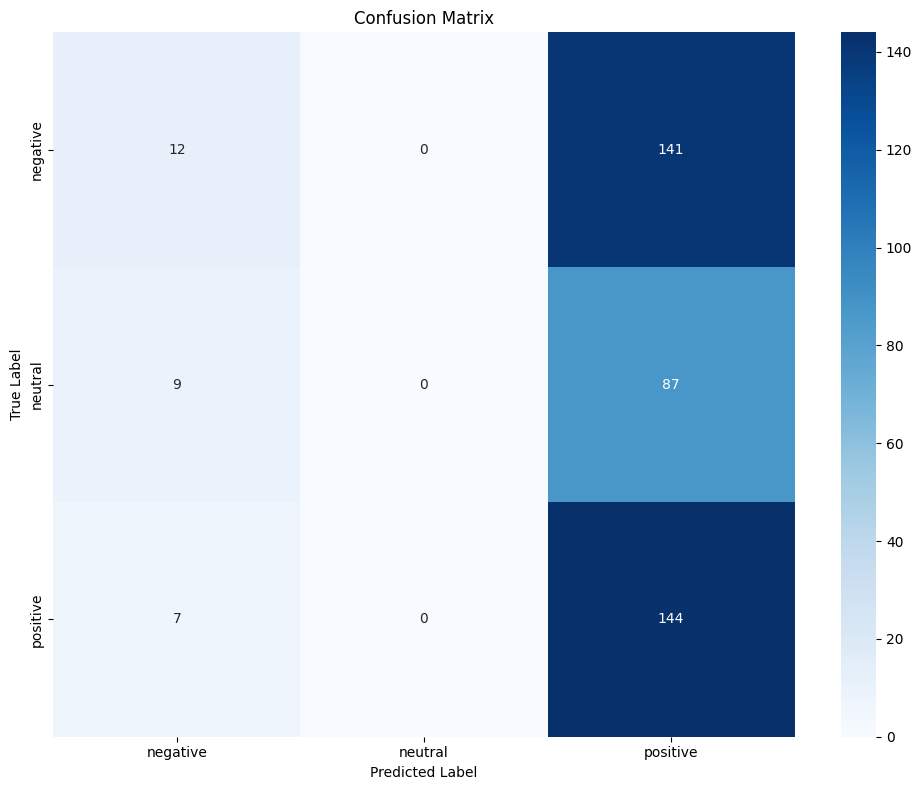


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 28 (7.0%)
  neutral: 0 (0.0%)
  positive: 372 (93.0%)

Prediction Confidence Analysis:
  Mean confidence: 0.3696
  Median confidence: 0.3681
  Min confidence: 0.3396
  Max confidence: 0.4069


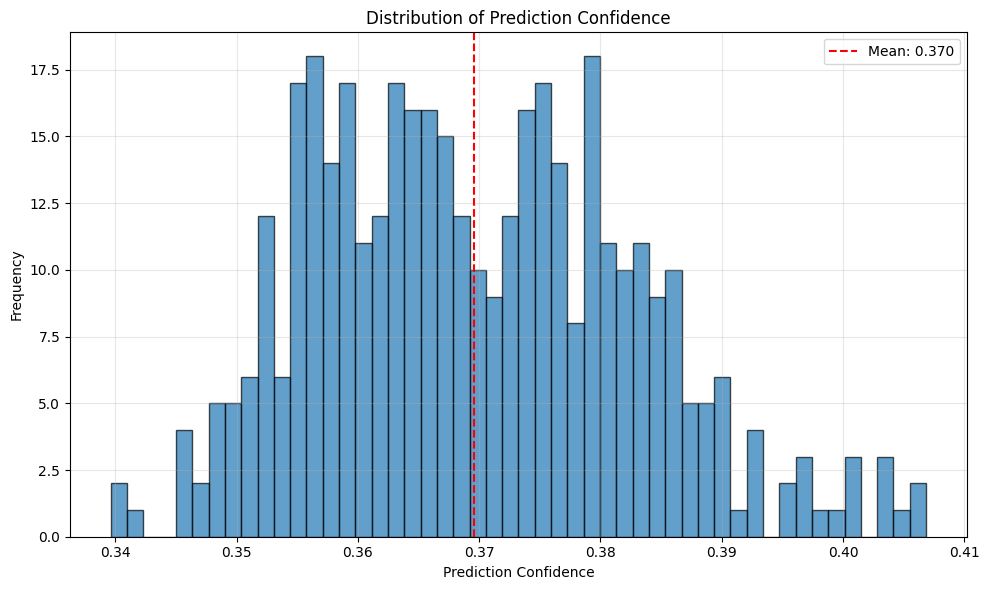


SCRATCH MODEL EVALUATION

COMPREHENSIVE EVALUATION
Accuracy: 0.3825
F1 Score (Macro): 0.1848
F1 Score (Weighted): 0.2120

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


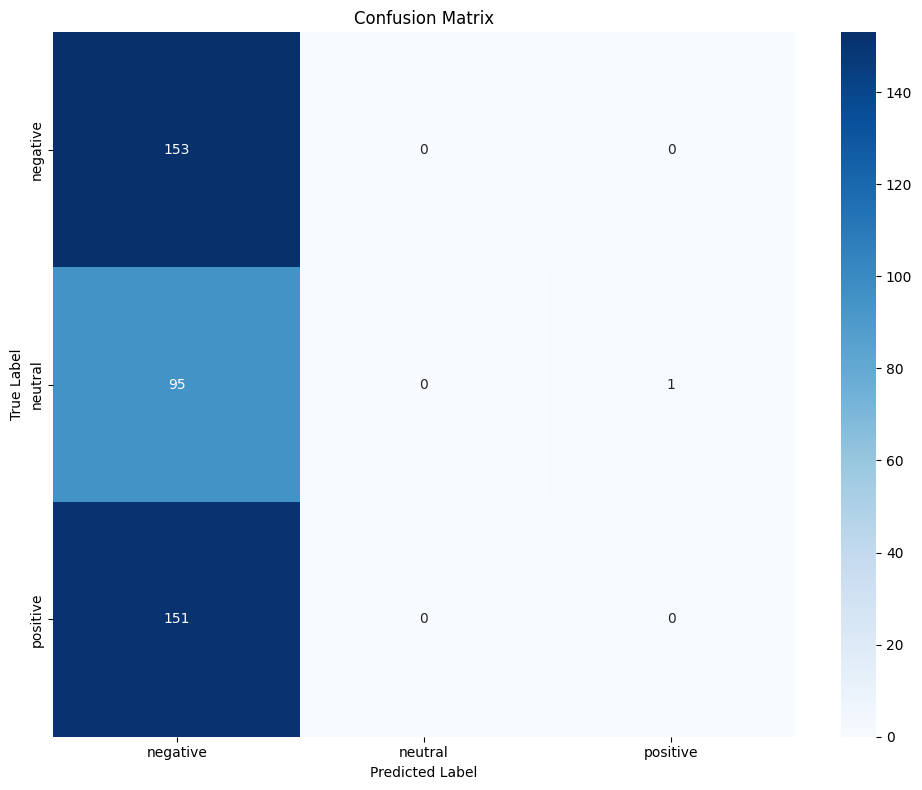


True Label Distribution:
  negative: 153 (38.2%)
  neutral: 96 (24.0%)
  positive: 151 (37.8%)

Predicted Label Distribution:
  negative: 399 (99.8%)
  neutral: 0 (0.0%)
  positive: 1 (0.2%)

Prediction Confidence Analysis:
  Mean confidence: 0.4188
  Median confidence: 0.4193
  Min confidence: 0.3490
  Max confidence: 0.4824


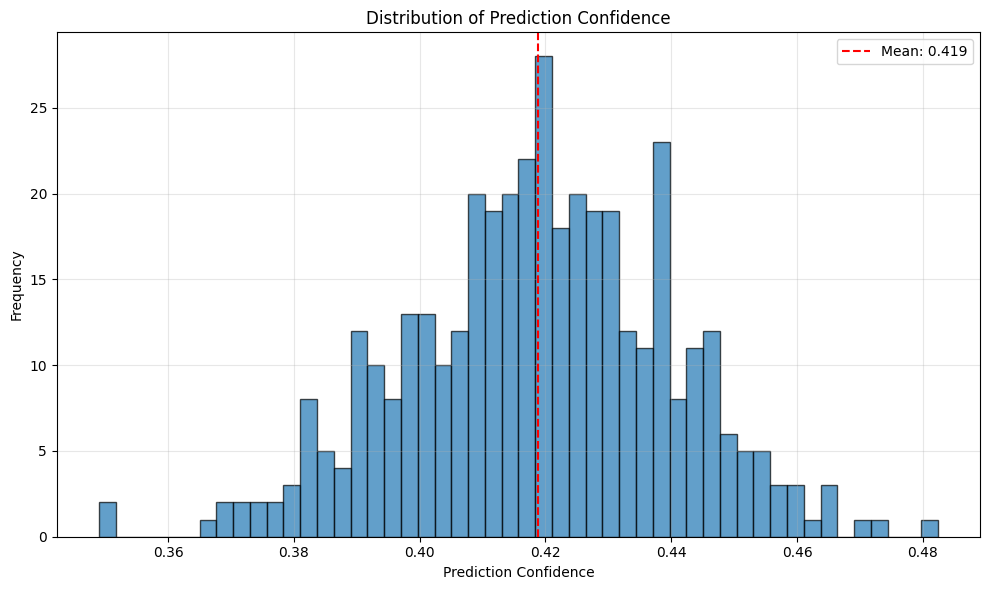


TESTING SUMMARY
Test 1 (Forward Propagation Match): FAIL
Test 2 (Scratch Consistency): PASS

Keras Model Performance:
  Accuracy: 0.3900
  F1 (Macro): 0.2278

Scratch Model Performance:
  Accuracy: 0.3825
  F1 (Macro): 0.1848
  Performance Difference: 0.0075

⚠️  Some tests failed or performance differs significantly.


In [23]:
# == TESTING FUNCTIONS == #

def test_forward_propagation(keras_model, scratch_model, X_test, y_test, vectorizer):
    """Test 1: Compare forward propagation between Keras model and scratch implementation"""
    print("=" * 60)
    print("TEST 1: Forward Propagation Comparison")
    print("=" * 60)

    # Test
    X_test_full = X_test
    y_test_full = y_test_numeric

    # Preprocess text data
    X_test_seq = vectorizer(X_test_full)

    # Keras model prediction
    print("Running Keras model prediction...")
    keras_pred = keras_model.predict(X_test_seq, verbose=0)

    # Scratch model prediction
    print("Running scratch model prediction...")
    scratch_pred = scratch_model.predict(X_test_full)

    # Compare predictions
    mse = np.mean((keras_pred - scratch_pred) ** 2)
    max_diff = np.max(np.abs(keras_pred - scratch_pred))
    mean_abs_diff = np.mean(np.abs(keras_pred - scratch_pred))

    print(f"Mean Squared Error: {mse:.8f}")
    print(f"Maximum Absolute Difference: {max_diff:.8f}")
    print(f"Mean Absolute Difference: {mean_abs_diff:.8f}")

    # Check if predictions are close enough
    if mse < 1e-6:
        print("✅ PASS: Forward propagation matches between Keras and scratch models")
    else:
        print("❌ FAIL: Forward propagation differs significantly")

    # Show some sample predictions
    print(f"\nSample predictions (first 5):")
    print("Keras predictions:")
    for i in range(min(5, len(keras_pred))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(keras_pred[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(keras_pred[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in keras_pred[i]]}")

    print("\nScratch predictions:")
    for i in range(min(5, len(scratch_pred))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(scratch_pred[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(scratch_pred[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in scratch_pred[i]]}")

    return mse < 1e-6

def test_scratch_consistency(scratch_model, X_test, y_test):
    """Test 2: Compare scratch model with and without backpropagation"""
    print("\n" + "=" * 60)
    print("TEST 2: Scratch Model Consistency (Forward vs Forward+Backward)")
    print("=" * 60)

    # Test
    X_test_full = X_test
    y_test_full = y_test_numeric

    # Forward pass only
    print("Running forward pass only...")
    pred_forward_only = scratch_model.predict(X_test_full)

    # Forward pass followed by backward pass
    print("Running forward + backward pass...")
    pred_with_backward = scratch_model.forward(X_test_full)

    # Simulate backward pass (doesn't change forward result)
    dummy_grad = np.ones_like(pred_with_backward)
    gradients = scratch_model.backward(dummy_grad, y_test_full)

    # Forward pass again to check consistency
    pred_after_backward = scratch_model.predict(X_test_full)

    # Compare predictions
    mse1 = np.mean((pred_forward_only - pred_with_backward) ** 2)
    mse2 = np.mean((pred_forward_only - pred_after_backward) ** 2)

    print(f"MSE (forward vs forward+backward): {mse1:.8f}")
    print(f"MSE (forward vs after backward): {mse2:.8f}")

    if mse1 < 1e-10 and mse2 < 1e-10:
        print("✅ PASS: Scratch model is consistent")
        print("Forward pass results remain unchanged after backward pass")
    else:
        print("❌ FAIL: Scratch model shows inconsistency")

    print(f"Backward pass computed gradients for {len(gradients)} layers")

    # Show some sample predictions
    print(f"\nSample predictions (first 5):")
    print("Forward predictions:")
    for i in range(min(5, len(pred_forward_only))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(pred_forward_only[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(pred_forward_only[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in pred_forward_only[i]]}")

    print("\nForward + Backward predictions:")
    for i in range(min(5, len(pred_after_backward))):
        true_label = reverse_label_mapping[y_test_full[i]]  # Get true label text
        pred_label_idx = np.argmax(pred_after_backward[i])  # Get predicted class index
        pred_label = reverse_label_mapping[pred_label_idx]  # Get predicted label text
        print(f"  Sample {i}:")
        print(f"    True label: {true_label}")
        print(f"    Predicted: {pred_label} (confidence: {np.max(pred_after_backward[i]):.2f})")
        print(f"    Probabilities: {[f'{p:.4f}' for p in pred_after_backward[i]]}")

    return mse1 < 1e-10 and mse2 < 1e-10

def comprehensive_evaluation(model, X_test, y_test, vectorizer, label_mapping):
    """Comprehensive evaluation with confusion matrix and class distribution"""
    print("\n" + "=" * 60)
    print("COMPREHENSIVE EVALUATION")
    print("=" * 60)

    # Use full test dataset
    if isinstance(X_test[0], str):
        X_test_seq = vectorizer(X_test)
        predictions = model.predict(X_test_seq if hasattr(model, 'predict') else X_test)
    else:
        predictions = model.predict(X_test)

    # Get predicted classes
    y_pred_classes = np.argmax(predictions, axis=1)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1_macro = f1_score(y_test, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Classification report
    reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
    target_names = [reverse_label_mapping[i] for i in range(len(label_mapping))]

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Class distribution analysis
    print(f"\nTrue Label Distribution:")
    true_dist = np.bincount(y_test)
    for i, count in enumerate(true_dist):
        label_name = reverse_label_mapping[i]
        percentage = count / len(y_test) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")

    print(f"\nPredicted Label Distribution:")
    pred_dist = np.bincount(y_pred_classes)
    for i, count in enumerate(pred_dist):
        label_name = reverse_label_mapping[i]
        percentage = count / len(y_pred_classes) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")

    # Prediction confidence analysis
    print(f"\nPrediction Confidence Analysis:")
    max_probs = np.max(predictions, axis=1)
    print(f"  Mean confidence: {np.mean(max_probs):.4f}")
    print(f"  Median confidence: {np.median(max_probs):.4f}")
    print(f"  Min confidence: {np.min(max_probs):.4f}")
    print(f"  Max confidence: {np.max(max_probs):.4f}")

    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(max_probs), color='red', linestyle='--', label=f'Mean: {np.mean(max_probs):.3f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.close('all')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'predictions': predictions,
        'predicted_classes': y_pred_classes
    }

def run_all_tests():
    """Run all tests and evaluations"""
    print("STARTING COMPREHENSIVE TESTING...")
    print("=" * 80)

    # Load models (assuming they exist from previous training)
    try:
        keras_model = load_model('best_rnn_model.h5')
        print("✅ Keras model loaded successfully")
    except:
        print("❌ Failed to load Keras model. Please run the training code first.")
        return

    # Create scratch model with backpropagation
    try:
        scratch_model = RNNModelFromScratchWithBackprop(
            'best_rnn_model.h5',
            'vectorizer_config.pkl',
            training_texts=X_train  # Pass training texts for vectorizer adaptation
        )
        print("✅ Scratch model with backprop created successfully")
    except Exception as e:
        print(f"❌ Failed to create scratch model: {e}")
        return

    # Run Test 1: Forward propagation comparison
    test1_passed = test_forward_propagation(keras_model, scratch_model, X_test, y_test_numeric, vectorizer)

    # Run Test 2: Scratch model consistency
    test2_passed = test_scratch_consistency(scratch_model, X_test, y_test_numeric)

    # Comprehensive evaluation on Keras model
    print("\n" + "=" * 60)
    print("KERAS MODEL EVALUATION")
    print("=" * 60)
    keras_results = comprehensive_evaluation(keras_model, X_test, y_test_numeric, vectorizer, label_mapping)

    # Comprehensive evaluation on Scratch model
    print("\n" + "=" * 60)
    print("SCRATCH MODEL EVALUATION")
    print("=" * 60)
    scratch_results = comprehensive_evaluation(scratch_model, X_test, y_test_numeric, vectorizer, label_mapping)

    # Summary
    print("\n" + "=" * 80)
    print("TESTING SUMMARY")
    print("=" * 80)
    print(f"Test 1 (Forward Propagation Match): {'PASS' if test1_passed else 'FAIL'}")
    print(f"Test 2 (Scratch Consistency): {'PASS' if test2_passed else 'FAIL'}")
    print(f"\nKeras Model Performance:")
    print(f"  Accuracy: {keras_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {keras_results['f1_macro']:.4f}")
    print(f"\nScratch Model Performance:")
    print(f"  Accuracy: {scratch_results['accuracy']:.4f}")
    print(f"  F1 (Macro): {scratch_results['f1_macro']:.4f}")

    performance_diff = abs(keras_results['accuracy'] - scratch_results['accuracy'])
    print(f"  Performance Difference: {performance_diff:.4f}")

    if test1_passed and test2_passed and performance_diff < 0.01:
        print(f"\n🎉 ALL TESTS PASSED! Implementation is correct.")
    else:
        print(f"\n⚠️  Some tests failed or performance differs significantly.")

    return {
        'test1_passed': test1_passed,
        'test2_passed': test2_passed,
        'keras_results': keras_results,
        'scratch_results': scratch_results,
        'performance_diff': performance_diff
    }

# == MAIN EXECUTION == #
if __name__ == "__main__":
    # Run all tests
    results = run_all_tests()